### Deep Learning Homework 4

1. Now that you have all the tools to train an MLP with high performance on MNIST, try reaching 0-loss (or 100% accuracy) on the training data (with a small epsilon, e.g. 99.99% training performance -- don't worry if you overfit!). The implementation is completely up to you. You just need to keep it an MLP without using fancy layers (e.g., keep the Linear layers, don't use Conv1d or something like this, don't use attention). You are free to use any LR scheduler or optimizer, any one of batchnorm/groupnorm, regularization methods... If you use something we haven't seen during lectures, please motivate your choice and explain (as briefly as possible) how it works.
2. Try reaching 0-loss on the training data with permuted labels. Assess the model on the test data (without permuted labels) and comment. Tip: To permute the labels, act on the trainset.targets with an appropriate torch function. Then, you can pass this "permuted" Dataset to a DataLoader like so: trainloader_permuted = torch.utils.data.DataLoader(trainset_permuted, batch_size=batch_size_train, shuffle=True). You can now use this DataLoader inside the training function. Additional view for motivating this exercise: 

In [38]:
import torch
from torch import nn
import pylab as plt
import numpy as np
from torch import optim
from torch.nn import functional as F

class Net(nn.Module):
    
    def __init__(self,nodes,activation): #aggiungere dopo tipi di nodi
        super(Net,self).__init__()
        
        if (len(nodes)-1)!=len(activation):
            print('in numero delle funzioni di attivazione è diverso da quello dei layer')
            #break
            
            
        #layers and activation functions
        self.activation=activation        
        self.layers=nn.ModuleList()#vai a vedere esattamente cosa fa
        for i in range(len(nodes)-1):
            self.layers.append(nn.Linear(nodes[i],nodes[i+1]))
            self.layers.append(activation[i+1])
            self.layers.append(nn.BatchNorm1d(nodes[i+1]))
            #torch.nn.init.xavier_uniform_(self.layers[i].weight) #serve per inizializzare i parametri in modo diverso
        
        
        #Name definition
        self.name=str(nodes[0])+'-'
        for activ,node in zip(activation,nodes[1:]):
            self.name=self.name+str(node)
            if activ==torch.sigmoid: self.name=self.name+'s'
            if activ==F.relu: self.name=self.name+'r'
            self.name=self.name+'-'
        self.name=self.name[:-1]
        
        
        #Variables useful for the training part
        self.train_history=[]
        self.val_history=[]
        self.lossFunc=nn.MSELoss()
        self.epochs=-1
        
    def forward(self,x):
        i=0
        for layer in self.layers:
            x = layer(x)

        return x

    def Train(self,dataset_train,dataset_test,batch_size=40,epochs=500,optimizer=optim.SGD,lr=1e-2,lr_decay=0.999):
        #Loading the data
        trainLoader=DataLoader(dataset_train,batch_size,shuffle=True)
        validLoader=DataLoader(dataset_test,batch_size,shuffle=True)        
        optimizer=optimizer(self.parameters(),lr=lr)
        scheduler=MultiplicativeLR(optimizer,lambda epoch:lr_decay,last_epoch=self.epochs)
        for epoch in range(self.epochs,self.epochs+epochs):
            for data,valid in zip(trainLoader,validLoader):
                optimizer.zero_grad()
                x,y=data
                xv,yv=valid

                out=self(x)
                outv=self(xv)
                loss=self.lossFunc(out,y)
                lossv=self.lossFunc(outv,yv)
                loss.backward()
                optimizer.step()                
                
                self.loss=loss.detach()
                self.lossv=lossv.detach()
                self.train_history.append(self.loss)
                self.val_history.append(self.lossv)
                scheduler.step()
        self.epochs=self.epochs+epochs
        
        
    def accuracy(self,dataset):
        x,y=dataset.x,dataset.y
        out=self(x)
        return self.lossFunc(out,y).item()
    
    def save(self,path='models/',name=None,save_img=True,save_net=True,img_title=None):
        if name==None: name=self.name
        if save_img==True:
            if img_title==None: img_title=name
            L=np.arange(len(self.train_history))
            plt.plot(L,self.train_history,label='Train')
            plt.plot(L,self.val_history,label='Test')
            plt.title(img_title)
            plt.xlabel('epoch')
            plt.ylabel('MSE loss')
            plt.legend(loc="upper right")
            plt.savefig(path+name+'.eps',format='eps')
            plt.close()
        if save_net==True:
            torch.save(self,path+name+'.torch')

In [39]:
net = Net([784,384,10], [F.relu, F.relu])

print(net.name)



TypeError: torch.nn.functional.relu is not a Module subclass

In [40]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import pylab as pl
from IPython.display import clear_output
import seaborn as sns
sns.set_theme()
import time


# Training and other functions
from scripts import *

In [41]:
# 1. Achieve 99.99% train set accuracy

# Define the model
class MLP(nn.Module):
    """
    Implements a neural network to train on MNIST 
    """
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(784, 384),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(384),
            torch.nn.Linear(384, 384),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(384),
            torch.nn.Linear(384, 384),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(384),
            torch.nn.Linear(384, 10)
        )
        
    def forward(self, X):        
        return self.layers(X)

In [42]:
# 1. Achieve 99.99% train set accuracy

# Define the model
class MLP(nn.Module):
    """
    Implements a neural network to train on MNIST 
    """
    def __init__(self):
        super().__init__()
        asd = [torch.nn.Flatten(),
            torch.nn.Linear(784, 384),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(384),
            torch.nn.Linear(384, 10)]
        self.layers = torch.nn.Sequential(*asd)
        
    def forward(self, X):        
        return self.layers(X)

In [46]:
# Load the data
import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize

# Change root_dir to the directory where to find MNIST
root_dir = '../data/'
transforms = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
    ])

# Training and test sets
train_set = torchvision.datasets.MNIST(root=root_dir, train=True, transform=transforms)
test_set = torchvision.datasets.MNIST(root=root_dir, train=False, transform=transforms)

# Create a training set with permuted labels
from copy import deepcopy

def shuffle(x):
    return x[torch.randperm(x.size()[0])]

train_set_permuted = deepcopy(train_set)
train_set_permuted.targets = shuffle(train_set_permuted.targets)

# Use only 10k train examples
train_set, _ = random_split(train_set, [10000, 50000])
train_set_permuted, _ = random_split(train_set_permuted, [10000, 50000])



# Create train and test loaders
batch_train, batch_test = 256, 512
train_loader = DataLoader(train_set, batch_size=batch_train, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_test, shuffle=False, num_workers=2)
train_loader_permuted = DataLoader(train_set_permuted, batch_size=batch_train,
                                   shuffle=True, num_workers=2)

In [44]:
def train_model(model, train_set, criterion, optimizer, n_epochs,
                val_set=None, val_criterion=None, scheduler=None):    
    """
    Trains a model, can keep track of learning metrics on validation set
    and implements early stopping
    
    Parameters
    ----------
    model: nn.Module
        Model to train
    
    train_set: DataLoader
        Training set
        
    criterion: loss function
        Loss function criterion
    
    optimizer: torch optimizer
        Optimizer to use to train the model
    
    n_epochs: int
        Number of epochs to train the model
    
    val_set: DataLoader
        Validation set to keep track of the generalization error, Default: None
    
    val_criterion: loss function with signature f(model, val_set) -> float
        Evaluation criterion on the test set, Default: Same as criterion
        
    scheduler: torch.optim.lr_scheduler
        Learning rate scheduler, default: None
        
    Returns
    -------
    float: 
        Loss on the training epoch
    """
    train_losses = []
    train_accuracies = []
    val_accuracies = []
        
    for epoch in range(n_epochs):
        clear_output(wait=True)
        
        t0 = time.time()
        # Model training
        train_loss = train_epoch(model, train_set, criterion, optimizer)
        train_losses.append(train_loss)
        
        # Train accuracy
        train_accuracy = 1-eval_model(model, train_set, val_criterion)
        train_accuracies.append(train_accuracy)
        
        # Test accuracy
        val_accuracy = 1-eval_model(model, val_set, val_criterion)
        val_accuracies.append(val_accuracy)
        
        # Step the scheduler
        scheduler.step()
        
        # Print progress
        print(f"""Epoch: {epoch}, time: {time.time() - t0} [s]
        Train loss: {train_loss}
        Train accuracy: {train_accuracy}
        Validation accuracy: {val_accuracy}""")
        pl.clf()
        pl.plot(train_accuracies)
        pl.plot(val_accuracies)
        pl.show()
            
        # Stop training
        if(train_accuracy > 1 - 1e-3):
            print("Reached early stopping!")
            break
        
    return train_losses, train_accuracies, val_accuracies
    

Epoch: 16, time: 6.055015563964844 [s]
        Train loss: 0.022142176759243012
        Train accuracy: 0.9992
        Validation accuracy: 0.9614999999165534


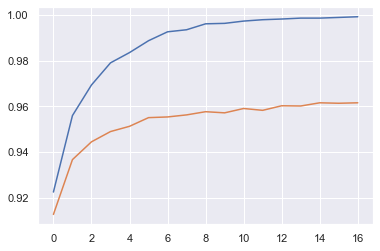

Reached early stopping!


In [55]:
# Train with Cross entropy and SGD
net = MLP()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
# I added a scheduler to help the optimizer to reach maximum accuracy on train data
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
_, train_accuracies, val_accuracies = train_model(net, train_loader, loss, optimizer, n_epochs=30, 
                                                  val_set=test_loader, val_criterion=accuracy, scheduler=scheduler)

In [36]:
train_accuracies[-1], val_accuracies[-1]

(0.9993, 0.9581999999046326)

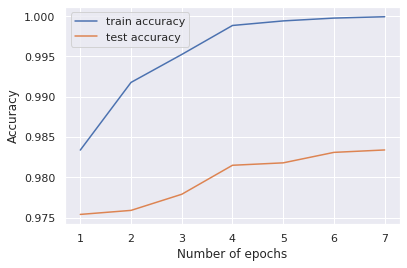

In [15]:
epochs = list(range(1, len(train_accuracies)+1))
pl.plot(epochs, train_accuracies, label="train accuracy")
pl.plot(epochs, val_accuracies, label="test accuracy")
pl.ylabel("Accuracy")
pl.xlabel("Number of epochs")
pl.legend()
pl.show()

We see that in 7 epochs we managed to reach 99.993% training accuracy, this is expected since our model has over 600k parameters and the training set is composed of 50k examples.  
Another very interesting result is that the test accuracy follows very closely the behaviour of the training accuracy even when the model is obviously overfitting, this means that the net manages to find general structure in the data even in overfitting regime.  

Epoch: 80, time: 3.9667153358459473 [s]
        Train loss: 0.04439091157913208
        Train accuracy: 0.9991
        Validation accuracy: 0.09120000076293944


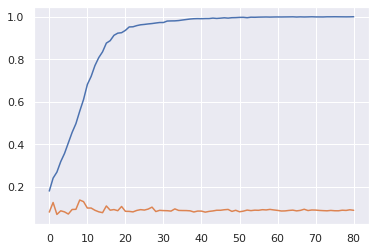

Reached early stopping!


In [53]:
# Train first net with Cross entropy and SGD
net = MLP()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())
# I added a scheduler to help the optimizer to reach maximum accuracy on train data
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
_, train_accuracies, val_accuracies = train_model(net, train_loader_permuted, loss, optimizer, n_epochs=300, 
                                                  val_set=test_loader, val_criterion=accuracy, scheduler=scheduler)

In [37]:
# Train first net with Cross entropy and SGD
net2 = MLP()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net2.parameters())
# I added a scheduler to help the optimizer to reach maximum accuracy on train data
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
_, train_accuracies, val_accuracies = train_model(net2, train_loader_permuted, loss, optimizer, n_epochs=300, 
                                                  val_set=test_loader, val_criterion=accuracy, scheduler=scheduler)

RuntimeError: DataLoader worker (pid(s) 8396, 2936) exited unexpectedly

In [71]:
def distance(f, g, dataset):
    f.eval()
    g.eval()
    res = 0.
    for data in dataset:
        inputs, _ = data
        res+=torch.sum(torch.max(f(inputs), 1).indices == torch.max(g(inputs), 1).indices)
    
    return res / 10000

distance(net, net2, test_loader)

tensor(0.2864)

In [10]:
train_accuracies[-1], val_accuracies[-1]

(0.9999666666666667, 0.10330000057220456)

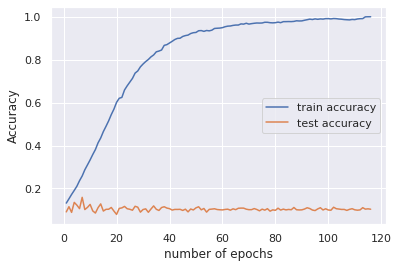

In [9]:
epochs = list(range(1,len(train_accuracies)+1))
pl.plot(epochs, train_accuracies, label="train accuracy")
pl.plot(epochs, val_accuracies, label="test accuracy")
pl.ylabel("Accuracy")
pl.xlabel("number of epochs")
pl.legend()
pl.show()

### Conclusion

After a much higher number of epochs(115 vs 7) we managed to reach 99.997% accuracy, from a mathematical point of view this is expected since we have much more free variables than number of "equations", however, from a practical point of view the net shouldn't be able to learn because there isn't actually anything to learn <sup>[[1]](https://arxiv.org/abs/1611.03530 "Understanding deep learning requires rethinking generalization")</sup>. The net in this case is like the student that memorizes everything instead of grasping the underlying concepts

Notice that we used a very big and over-parametrized network, we tried smaller networks but the classifier doesn't reach 99.99% accuracy, we also tried to change the optimizer or add weight decay but we didn't see any big improvement, the biggest improvement we experienced was by adding more layers or widening the existing ones.  

Another advantage of a bigger network is that we reduced training time in the true labels case, this seems unintuitive because a bigger network requires more computational time to evaluate, however, on our computer, we see that by shrinking the same network to 128 units per layer we need 14 epochs each of which takes 13s to reach 99.99% accuracy, while the bigger network that we used takes 17s per epoch but only needs 7 epochs, that is a 1.5x speedup.